In [1]:
import torch
import numpy as np
import torchvision
import pandas as pd
import bisect
import os
import glob
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import time
from heapq import heappop, heappush, heapify
from collections import defaultdict


import matplotlib.pyplot as plt

In [2]:
from src.utils.network import SupConResNet_v
from src.utils.loss import SupConLoss
from src.utils.stem_dataset import STEMDataset, ToTensor, collate_fn, RandomCrop, \
STEMTestdata, STEMEvaluator, STEMVisualization

## Parameters you may need to change

In [3]:
# csv_file = "<change_the_path>/atomagined/key.csv" # path to the annotation file
# root_dir = "<change_the_path>/atomagined/general/png/" # dir of the STEM images
csv_file = "/home/weixin/Documents/data/MaterialEyes/atomagined/key.csv" # path to the annotation file
root_dir = "/home/weixin/Documents/data/MaterialEyes/atomagined/general/png/" # dir of the STEM images
device="cuda:0" # parameter for gpu id selectoin (in case of more than one gpu)

In [4]:
start = time.time()
testset = STEMTestdata(csv_file, root_dir)
symtable_ids = {v: idx for idx,v in enumerate(testset.symtable2img.keys())}
icsd_ids = {v: idx for idx,v in enumerate(testset.icsd2img.keys())}
val_data, val_label = [t.path for t in testset.val], [t.icsd_id for t in testset.val]
print("loading dataset. Time elapsed %.2f"%(time.time()-start))
len(val_data), len(val_label)

loading dataset. Time elapsed 59.83


(16128, 16128)

# Test

In [5]:
evaluator = STEMEvaluator()
visualizer = STEMVisualization()

In [6]:
# imagenet pretrain model
resnet18_pretrained = models.resnet18(pretrained=True)
encoder = nn.Sequential(*list(resnet18_pretrained.children())[:-1])
encoder.to(device)
encoder = encoder.eval()

preds_pt, sim_scores_pt, AP_pt, mAP_pt = evaluator.computeAP(encoder, val_data, batch_size=64, true_labels=val_label)

# finetuned with icsd similarity (no head) + icsd classification
net = SupConResNet_v(name='resnet18', head=None, cls=None, feat_dim=128) # simcCLR no head
net.load_state_dict(torch.load("resnet18_cls_icsd_sim_nohead_epoch189.pt", map_location="cpu"), strict=False)
encoder = net.encoder
encoder.to(device)
encoder = encoder.eval()

preds_cts_icsd, sim_scores_cts_icsd, AP_cts_icsd, mAP_cts_icsd = evaluator.computeAP(encoder, val_data, batch_size=16, true_labels=val_label)



100%|██████████| 16128/16128 [00:34<00:00, 470.91data/s]


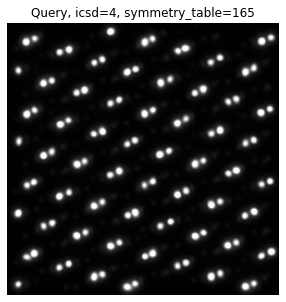

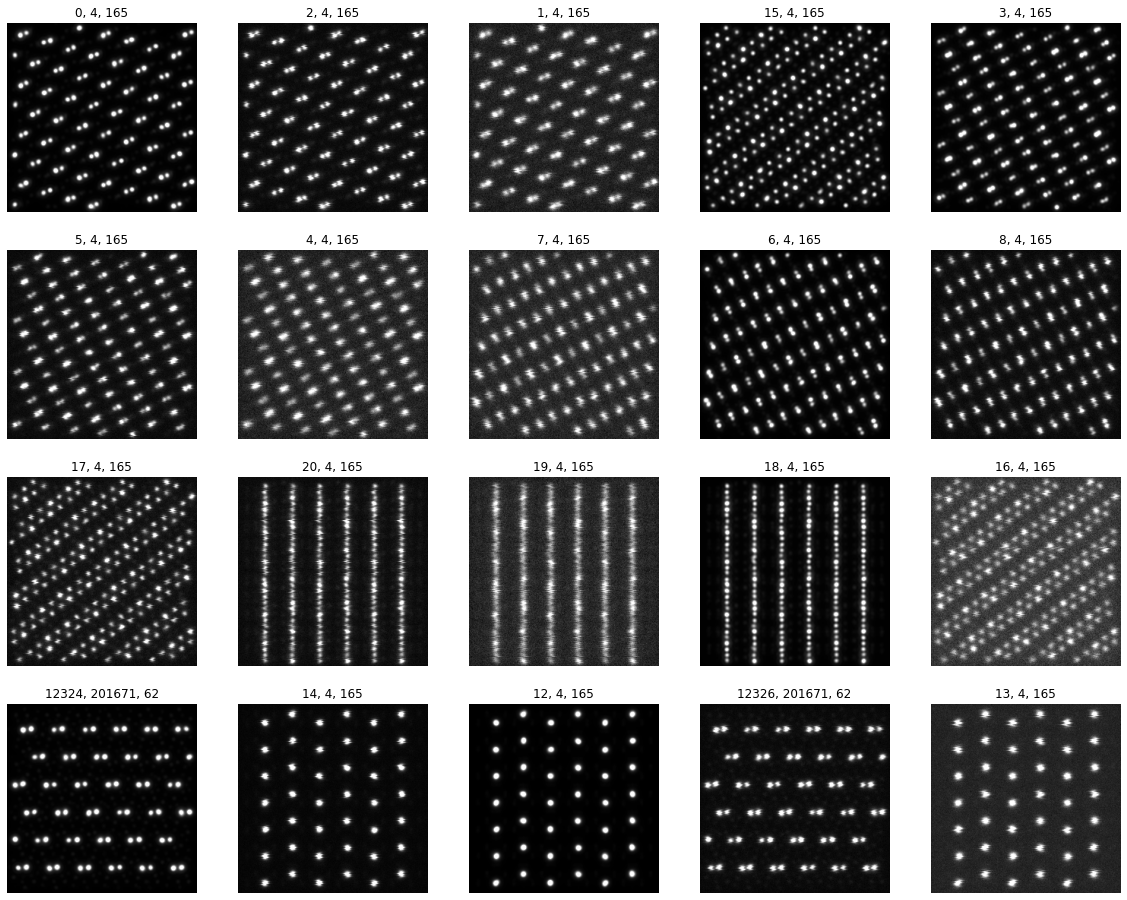

In [7]:
# retrieval results of sample input
"""
idx: index of the query image
data: list of <STEMData>
scores: computed similarity matrix
cand_counts: number of retrieved results to show
save: Not implementated yet
"""
visualizer.showExample(idx=0, data=testset.val, \
                       scores=sim_scores_cts_icsd, cand_counts = 20, save=False)




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

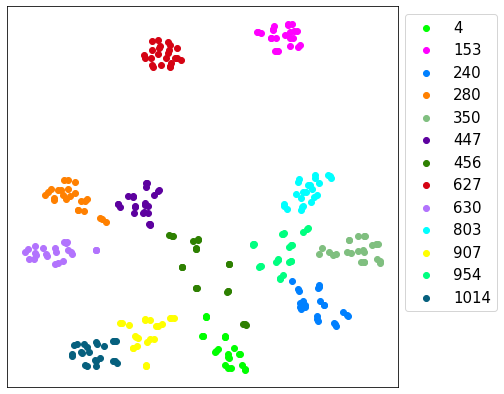

In [8]:
# manifold of learned representations
"""
features: learned representations with a size of (num_samples, feat_dim)
labels: labels for learned representaions
num_data: number of data points to plot
"""
visualizer.showManifold(features=preds_cts_icsd, labels=val_label, num_data=24*13)

